# Data cleaning, description, exploration, missing values


In [75]:

import numpy as np
import pandas as pd


# imports from third-party modules
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import requests
from requests.compat import urljoin
import sklearn
import seaborn as sns

from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats


import missingno as msno

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.cluster import KMeans


# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

SEED = 888

In [4]:
df_knee_ccg = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/knee-ccg.parquet?raw=true')

In [5]:
df_hip_ccg = pd.read_parquet('https://github.com/dkapitan/jads-nhs-proms/blob/master/data/interim/hip-ccg.parquet?raw=true')

In [6]:
df_knee_ccg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136390 entries, 0 to 136389
Data columns (total 81 columns):
 #   Column                        Non-Null Count   Dtype   
---  ------                        --------------   -----   
 0   provider_code                 136390 non-null  category
 1   procedure                     136390 non-null  category
 2   revision_flag                 136390 non-null  uint8   
 3   year                          136390 non-null  category
 4   age_band                      130099 non-null  category
 5   gender                        130099 non-null  float32 
 6   t0_assisted                   136390 non-null  uint8   
 7   t0_assisted_by                136390 non-null  uint8   
 8   t0_symptom_period             136390 non-null  uint8   
 9   t0_previous_surgery           136390 non-null  uint8   
 10  t0_living_arrangements        136390 non-null  uint8   
 11  t0_disability                 136390 non-null  uint8   
 12  heart_disease                 

In [5]:
df_hip_ccg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122294 entries, 0 to 122293
Data columns (total 81 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   provider_code                122294 non-null  category
 1   procedure                    122294 non-null  category
 2   revision_flag                122294 non-null  uint8   
 3   year                         122294 non-null  category
 4   age_band                     115948 non-null  category
 5   gender                       115948 non-null  float32 
 6   t0_assisted                  122294 non-null  uint8   
 7   t0_assisted_by               122294 non-null  uint8   
 8   t0_symptom_period            122294 non-null  uint8   
 9   t0_previous_surgery          122294 non-null  uint8   
 10  t0_living_arrangements       122294 non-null  uint8   
 11  t0_disability                122294 non-null  uint8   
 12  heart_disease                122294 non-null

In [7]:
# Exclude patients who had a revision operation as opposed to a primary procedure.
# number of hip revisions = 6237
# total number of hip records = 122294
# Total number of hip records without revision should be: 116057

#revisions = df_hip_ccg.query("revision_flag == 1")
#revisions.describe()

df_hip = df_hip_ccg.query("revision_flag == 0")
df_hip["revision_flag"].describe()


count    116057.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: revision_flag, dtype: float64

In [8]:
# Exclude patients who had a revision operation as opposed to a primary procedure.
# number of knee revisions = 5071
# total number of knee records = 136390
# Total number of knee records without revision should be: 131319

#revisions = df_knee_ccg.query("revision_flag == 1")
#revisions.describe()

df_knee = df_knee_ccg.query("revision_flag == 0")
df_knee["revision_flag"].describe()

count    131319.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: revision_flag, dtype: float64

Group items that belong to the same health questionnaire or type of variable.

In [10]:
EQ5D_t0_cols = ["t0_mobility", 
                "t0_self_care", 
                "t0_activity", 
                "t0_discomfort", 
                "t0_anxiety"]

EQ5D_t1_cols = ["t1_mobility", 
                "t1_self_care", 
                "t1_activity", 
                "t1_discomfort", 
                "t1_anxiety"]

OKS_t0_cols = ["oks_t0_pain", 
               "oks_t0_night_pain", 
               "oks_t0_washing", 
               "oks_t0_transport", 
               "oks_t0_walking", 
               "oks_t0_standing", 
               "oks_t0_limping", 
               "oks_t0_kneeling", 
               "oks_t0_work", 
               "oks_t0_confidence", 
               "oks_t0_shopping", 
               "oks_t0_stairs"]


OKS_t1_cols = ["oks_t1_pain", 
               "oks_t1_night_pain", 
               "oks_t1_washing", 
               "oks_t1_transport", 
               "oks_t1_walking", 
               "oks_t1_standing", 
               "oks_t1_limping", 
               "oks_t1_kneeling", 
               "oks_t1_work", 
               "oks_t1_confidence", 
               "oks_t1_shopping", 
               "oks_t1_stairs"]


OHS_t0_cols = ["ohs_t0_pain", 
               "ohs_t0_sudden_pain", 
               "ohs_t0_night_pain", 
               "ohs_t0_washing", 
               "ohs_t0_transport", 
               "ohs_t0_dressing", 
               "ohs_t0_shopping", 
               "ohs_t0_walking", 
               "ohs_t0_limping",
               "ohs_t0_stairs",
               "ohs_t0_standing",  
               "ohs_t0_work"]


OHS_t1_cols = ["ohs_t1_pain", 
               "ohs_t1_sudden_pain", 
               "ohs_t1_night_pain", 
               "ohs_t1_washing", 
               "ohs_t1_transport", 
               "ohs_t1_dressing", 
               "ohs_t1_shopping", 
               "ohs_t1_walking", 
               "ohs_t1_limping",
               "ohs_t1_stairs",
               "ohs_t1_standing",  
               "ohs_t1_work"]


Comorbidity_cols = ["heart_disease",
                   "high_bp",
                   "stroke",
                   "circulation",
                   "lung_disease",
                   "diabetes",
                   "kidney_disease",
                   "nervous_system",
                   "liver_disease",
                   "cancer",
                   "depression",
                   "arthritis"]

TotalScoresKnee_cols = ["t0_eq5d_index",
                   "t1_eq5d_index",
                   "t0_eq_vas",
                   "t1_eq_vas",
                   "oks_t0_score",
                   "oks_t1_score"]

TotalScoresHip_cols = ["t0_eq5d_index",
                   "t1_eq5d_index",
                   "t0_eq_vas",
                   "t1_eq_vas",
                   "ohs_t0_score",
                   "ohs_t1_score"]

EvaluationSurgery_cols = ["t1_satisfaction",
                          "t1_sucess"]
           
SurgeryComplications_cols = ["t1_allergy",
                             "t1_bleeding",
                             "t1_wound",
                             "t1_urine",
                             "t1_further_surgery",
                             "t1_readmitted"]
   

In [46]:
df_knee.keys()

Index(['provider_code', 'procedure', 'revision_flag', 'year', 'age_band',
       'gender', 't0_assisted', 't0_assisted_by', 't0_symptom_period',
       't0_previous_surgery', 't0_living_arrangements', 't0_disability',
       'heart_disease', 'high_bp', 'stroke', 'circulation', 'lung_disease',
       'diabetes', 'kidney_disease', 'nervous_system', 'liver_disease',
       'cancer', 'depression', 'arthritis', 't0_mobility', 't0_self_care',
       't0_activity', 't0_discomfort', 't0_anxiety', 't0_eq5d_index_profile',
       't0_eq5d_index', 't1_assisted', 't1_assisted_by',
       't1_living_arrangements', 't1_disability', 't1_mobility',
       't1_self_care', 't1_activity', 't1_discomfort', 't1_anxiety',
       't1_satisfaction', 't1_sucess', 't1_allergy', 't1_bleeding', 't1_wound',
       't1_urine', 't1_further_surgery', 't1_readmitted',
       't1_eq5d_index_profile', 't1_eq5d_index',
       'oks_eq_5d_index_t1_predicted', 't0_eq_vas', 't1_eq_vas',
       'oks_eq_vas_t1_predicted', 'oks

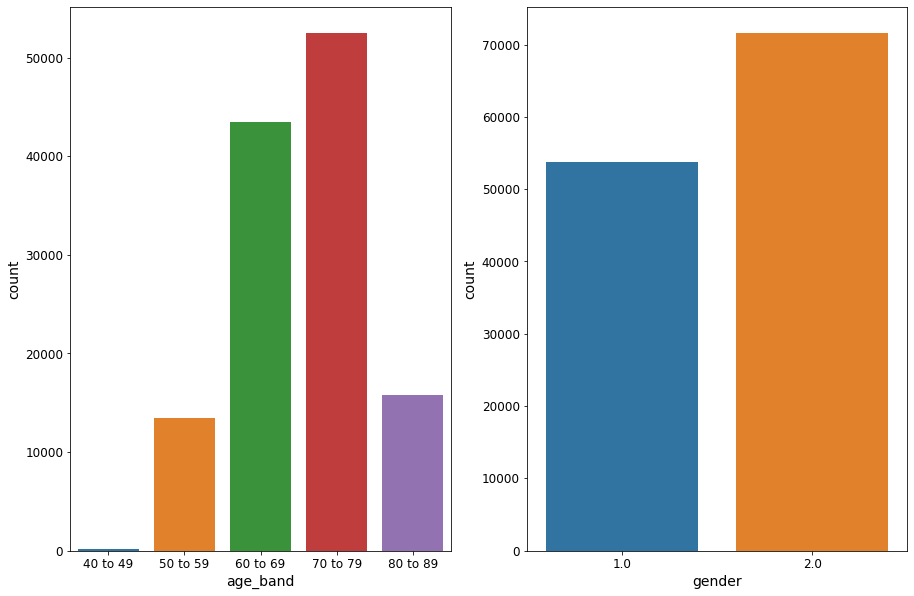

In [47]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
sns.countplot(x=df_knee.age_band, ax=ax[0])
sns.countplot(x=df_knee.gender, ax=ax[1])
plt.show()

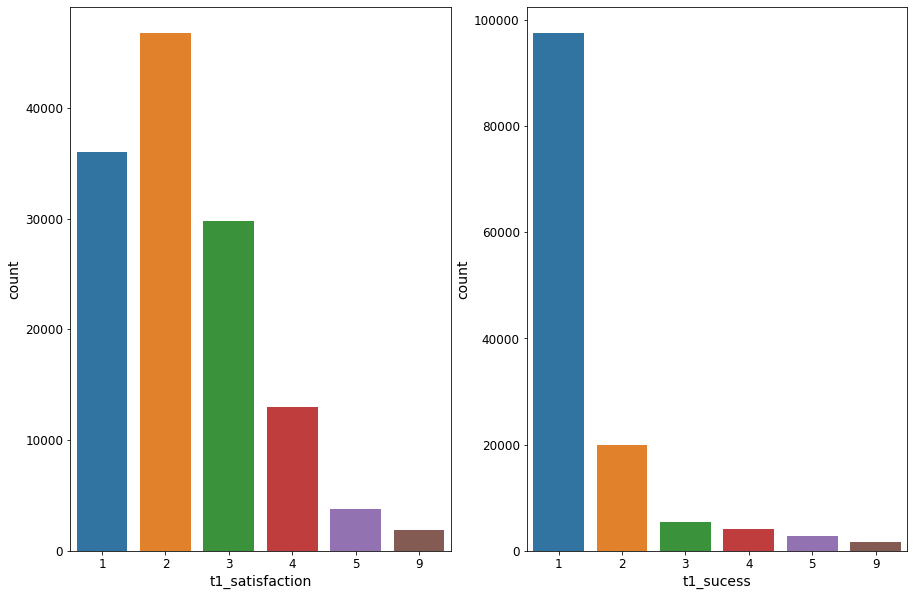

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
sns.countplot(x=df_knee.t1_satisfaction, ax=ax[0])
sns.countplot(x=df_knee.t1_sucess, ax=ax[1])
plt.show()

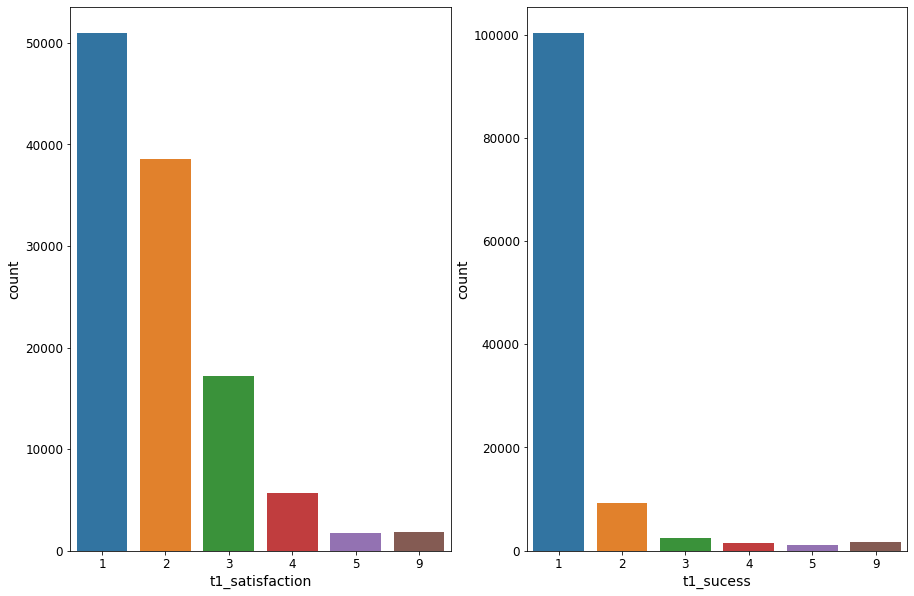

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(15,10))
sns.countplot(x=df_hip.t1_satisfaction, ax=ax[0])
sns.countplot(x=df_hip.t1_sucess, ax=ax[1])
plt.show()


In [20]:
# df[(df>=-200) & (df<=-100)] = np.nan
# traindata.loc[:, numeric_columns] = traindata.loc[:, numeric_columns].fillna(value=median_numeric_columns)
# df.loc[:, (df>=-200) & (df<=-100)] = np.nan


df_knee[EQ5D_t0_cols] = df_knee[EQ5D_t0_cols].replace({9:np.nan})


In [21]:
df_knee[EQ5D_t0_cols].describe().transpose()


,count,mean,std,min,25%,50%,75%,max
t0_mobility,127273.0,1.921492,0.278021,1.0,2.0,2.0,2.0,3.0
t0_self_care,127153.0,1.304767,0.475108,1.0,1.0,1.0,2.0,3.0
t0_activity,127071.0,2.027095,0.464356,1.0,2.0,2.0,2.0,3.0
t0_discomfort,126083.0,2.373333,0.504574,1.0,2.0,2.0,3.0,3.0
t0_anxiety,126459.0,1.399497,0.563801,1.0,1.0,1.0,2.0,3.0


In [22]:
df_knee[EQ5D_t1_cols] = df_knee[EQ5D_t1_cols].replace({9:np.nan})


In [23]:
df_knee[EQ5D_t1_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t1_mobility,128550.0,1.438250,0.498645,1.0,1.0,1.0,2.0,3.0
t1_self_care,128777.0,1.164268,0.383639,1.0,1.0,1.0,1.0,3.0
t1_activity,128466.0,1.527385,0.561662,1.0,1.0,1.0,2.0,3.0
t1_discomfort,127635.0,1.652627,0.562579,1.0,1.0,2.0,2.0,3.0
t1_anxiety,128352.0,1.232875,0.474296,1.0,1.0,1.0,1.0,3.0


In [24]:
df_knee[OKS_t0_cols] = df_knee[OKS_t0_cols].replace({9:np.nan})
#df_knee[OKS_t0_cols].describe().transpose()

In [25]:
df_knee[OKS_t1_cols] = df_knee[OKS_t1_cols].replace({9:np.nan})
#df_knee[OKS_t1_cols].describe().transpose()

In [26]:
df_hip[EQ5D_t0_cols] = df_hip[EQ5D_t0_cols].replace({9:np.nan})

#df_hip[EQ5D_t0_cols].describe().transpose()

In [27]:
df_hip[EQ5D_t1_cols] = df_hip[EQ5D_t1_cols].replace({9:np.nan})

#df_hip[EQ5D_t1_cols].describe().transpose()

In [28]:
df_hip[OHS_t0_cols] = df_hip[OHS_t0_cols].replace({9:np.nan})
#df_hip[OHS_t0_cols].describe().transpose()

In [29]:
df_hip[OHS_t1_cols] = df_hip[OHS_t1_cols].replace({9:np.nan})
#df_hip[OHS_t1_cols].describe().transpose()

In [32]:
df_knee[TotalScoresKnee_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t0_eq5d_index,124290.0,0.415207,0.311663,-0.594,0.088,0.587,0.691,1.0
t1_eq5d_index,125460.0,0.750292,0.246881,-0.594,0.691,0.779,1.000,1.0
t0_eq_vas,131319.0,154.102042,271.334901,0.000,55.000,75.000,89.000,999.0
t1_eq_vas,131319.0,118.103108,195.549505,0.000,70.000,80.000,90.000,999.0
oks_t0_score,129763.0,19.074999,7.718816,0.000,13.000,19.000,24.000,48.0
oks_t1_score,128897.0,36.132401,9.305695,0.000,31.000,38.000,43.000,48.0


In [33]:
df_hip[TotalScoresHip_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t0_eq5d_index,109550.0,0.341953,0.322115,-0.594,0.055,0.516,0.623,1.0
t1_eq5d_index,111135.0,0.802394,0.239217,-0.594,0.691,0.848,1.000,1.0
t0_eq_vas,116057.0,147.976873,268.888144,0.000,50.000,70.000,85.000,999.0
t1_eq_vas,116057.0,121.982853,198.124357,0.000,70.000,80.000,90.000,999.0
ohs_t0_score,114745.0,17.581680,8.088721,0.000,11.000,17.000,23.000,48.0
ohs_t1_score,114768.0,39.977356,8.481663,0.000,36.000,43.000,47.000,48.0


In [34]:
cols = ["t0_eq_vas", "t1_eq_vas"]
df_knee[cols] = df_knee[cols].replace({999:np.nan})
df_hip[cols] = df_hip[cols].replace({999:np.nan})

In [35]:
df_knee[TotalScoresKnee_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t0_eq5d_index,124290.0,0.415207,0.311663,-0.594,0.088,0.587,0.691,1.0
t1_eq5d_index,125460.0,0.750292,0.246881,-0.594,0.691,0.779,1.000,1.0
t0_eq_vas,119100.0,67.420193,20.596788,0.000,50.000,70.000,80.000,100.0
t1_eq_vas,125200.0,75.050327,18.155417,0.000,68.000,80.000,90.000,100.0
oks_t0_score,129763.0,19.074999,7.718816,0.000,13.000,19.000,24.000,48.0
oks_t1_score,128897.0,36.132401,9.305695,0.000,31.000,38.000,43.000,48.0


In [36]:
df_hip[TotalScoresHip_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t0_eq5d_index,109550.0,0.341953,0.322115,-0.594,0.055,0.516,0.623,1.0
t1_eq5d_index,111135.0,0.802394,0.239217,-0.594,0.691,0.848,1.000,1.0
t0_eq_vas,105584.0,63.562898,22.534266,0.000,50.000,70.000,80.000,100.0
t1_eq_vas,110463.0,77.569485,17.802107,0.000,70.000,80.000,90.000,100.0
ohs_t0_score,114745.0,17.581680,8.088721,0.000,11.000,17.000,23.000,48.0
ohs_t1_score,114768.0,39.977356,8.481663,0.000,36.000,43.000,47.000,48.0


In [37]:
df_knee[TotalScoresKnee_cols].corr()
#.sort_values(ascending=False)

,t0_eq5d_index,t1_eq5d_index,t0_eq_vas,t1_eq_vas,oks_t0_score,oks_t1_score
t0_eq5d_index,1.000000,0.321925,0.340656,0.268554,0.697176,0.288302
t1_eq5d_index,0.321925,1.000000,0.266102,0.607656,0.334962,0.752941
t0_eq_vas,0.340656,0.266102,1.000000,0.368729,0.359545,0.245954
t1_eq_vas,0.268554,0.607656,0.368729,1.000000,0.292532,0.567077
oks_t0_score,0.697176,0.334962,0.359545,0.292532,1.000000,0.349003
oks_t1_score,0.288302,0.752941,0.245954,0.567077,0.349003,1.000000


In [38]:
df_knee[EvaluationSurgery_cols] = df_knee[EvaluationSurgery_cols].replace({9:np.nan})
df_knee[EvaluationSurgery_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t1_satisfaction,129417.0,2.240162,1.055839,1.0,1.0,2.0,3.0,5.0
t1_sucess,129678.0,1.415707,0.875468,1.0,1.0,1.0,1.0,5.0


In [39]:
df_hip[EvaluationSurgery_cols] = df_hip[EvaluationSurgery_cols].replace({9:np.nan})
df_hip[EvaluationSurgery_cols].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
t1_satisfaction,114233.0,1.850017,0.954967,1.0,1.0,2.0,2.0,5.0
t1_sucess,114394.0,1.196252,0.619432,1.0,1.0,1.0,1.0,5.0


In [40]:
## more cleaning
# comorbidity variables: recode 9 to nan
# gender: recode 1,2,9 to 1,0,nan
# living arrangements 
# disability, yes, no, 9=nan
# previous surgery: yes, no, 9=nan
# symptom period: 1 = Less than 1 year, 2 = 1 to 5 years, 3 = 6 to 10 years, 
# 4 = More than 10 years, 9 = nan
# surgery complication variables: 1=yes, 2=no, 9=missing


In [41]:
import missingno as msno

<AxesSubplot:>

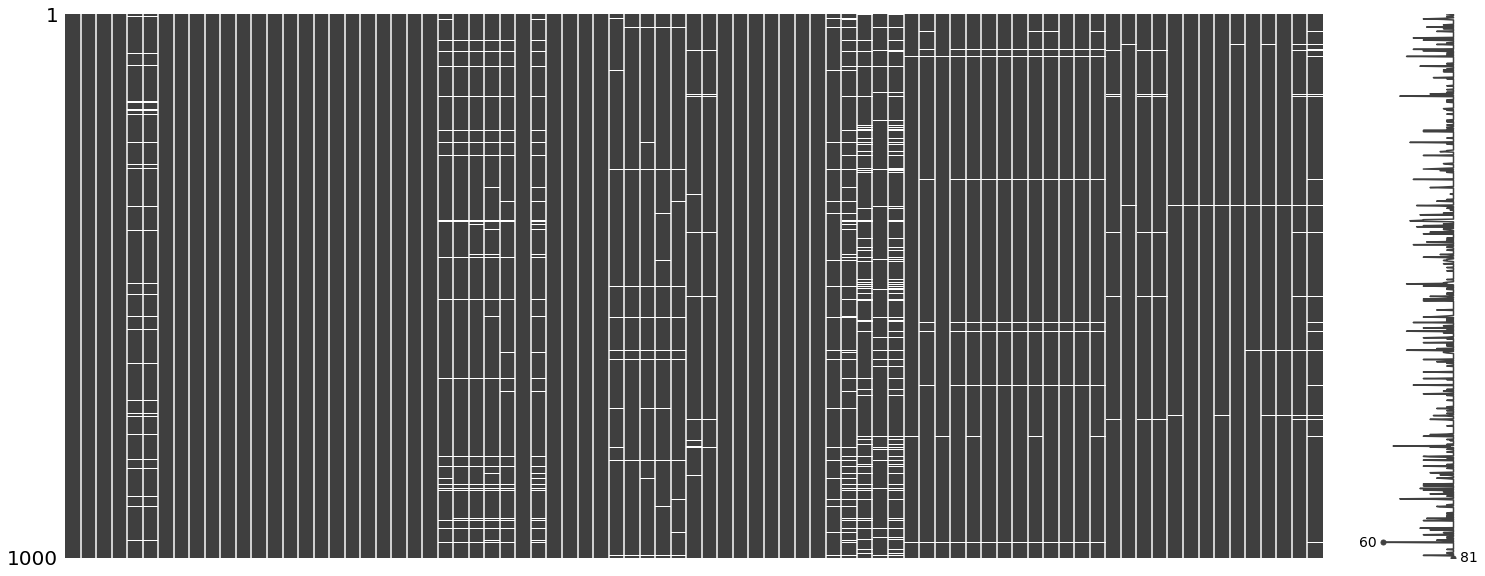

In [26]:
#msno.matrix(df_knee)
%matplotlib inline
msno.matrix(df_knee.sample(1000))

<AxesSubplot:>

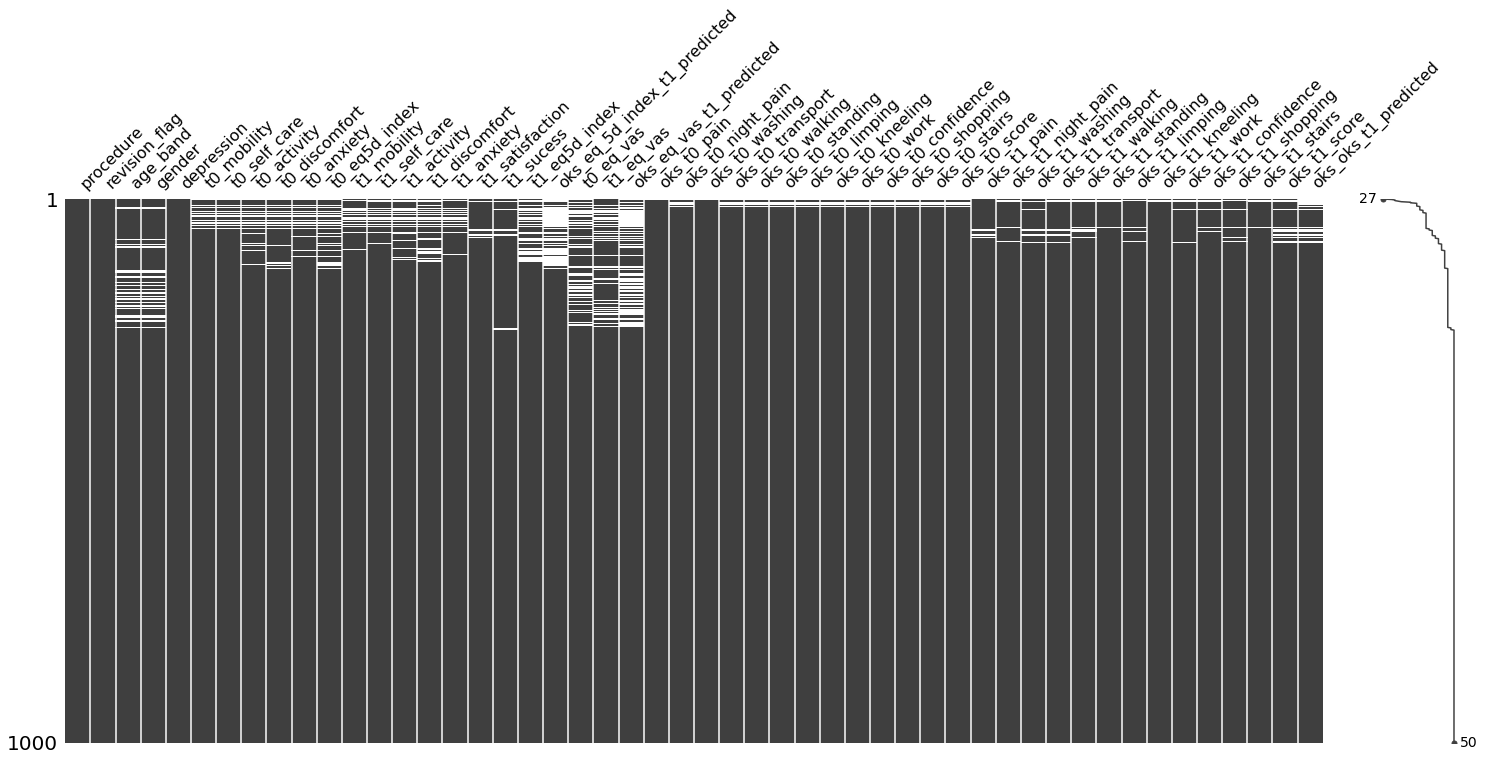

In [53]:
msno.matrix(#df_knee,
            df_knee.sample(1000), 
            filter='bottom', 
            n=50, 
            #p=0.5, 
            sort='ascending')

<AxesSubplot:>

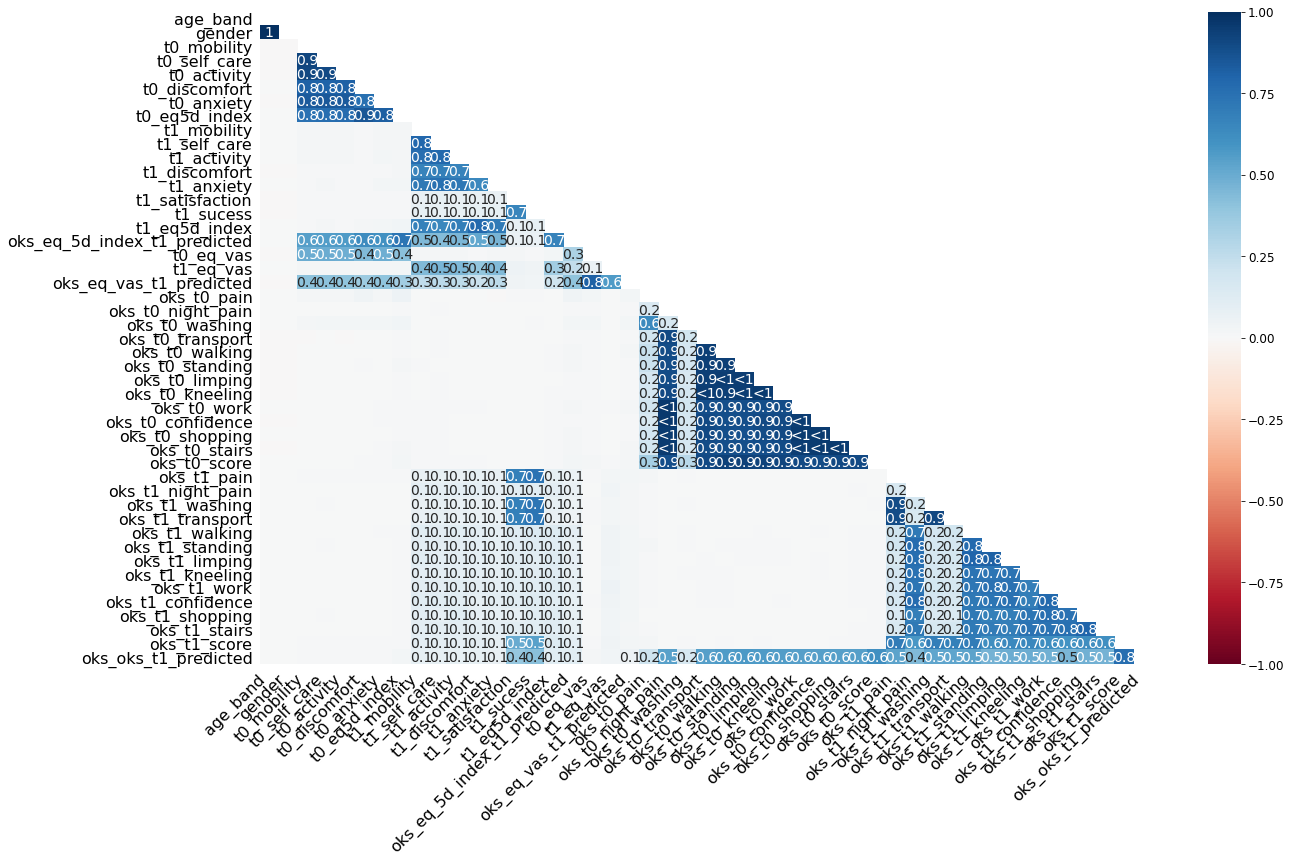

In [29]:
%matplotlib inline
msno.heatmap(df_knee)

In [ ]:
msno.heatmap(df_hip)

<AxesSubplot:>

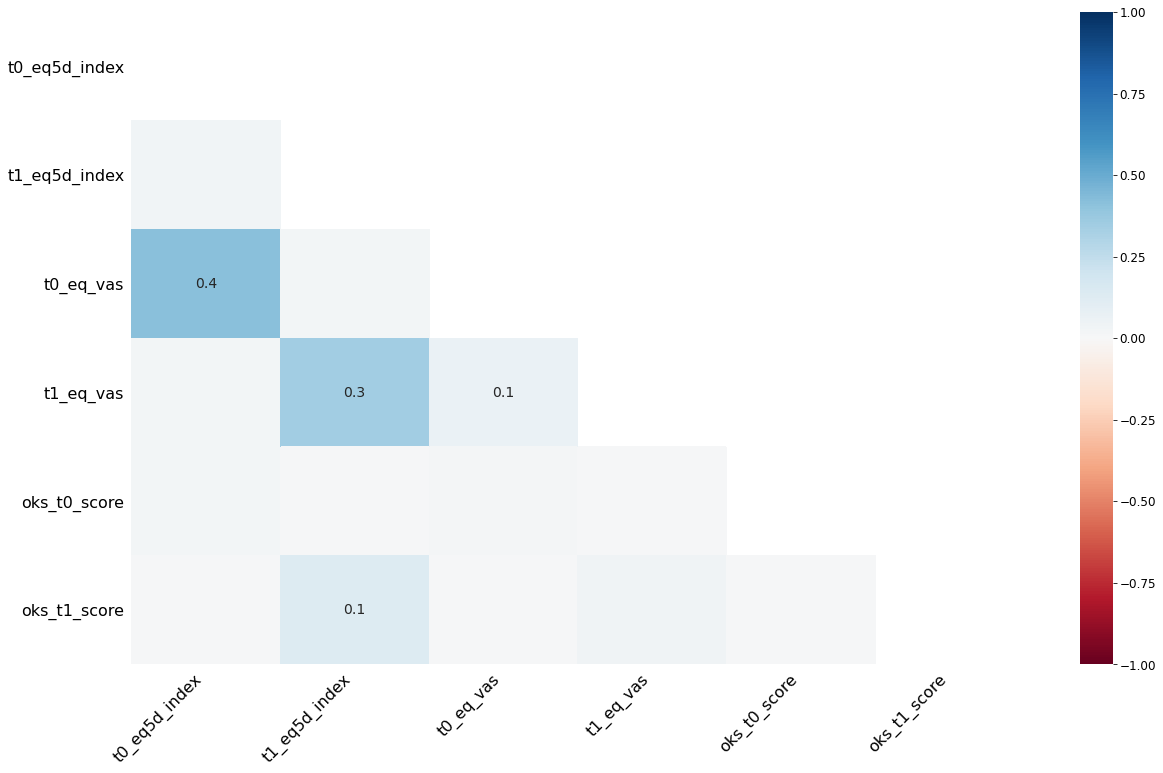

In [37]:
msno.heatmap(df_knee[TotalScoresKnee_cols])

<AxesSubplot:>

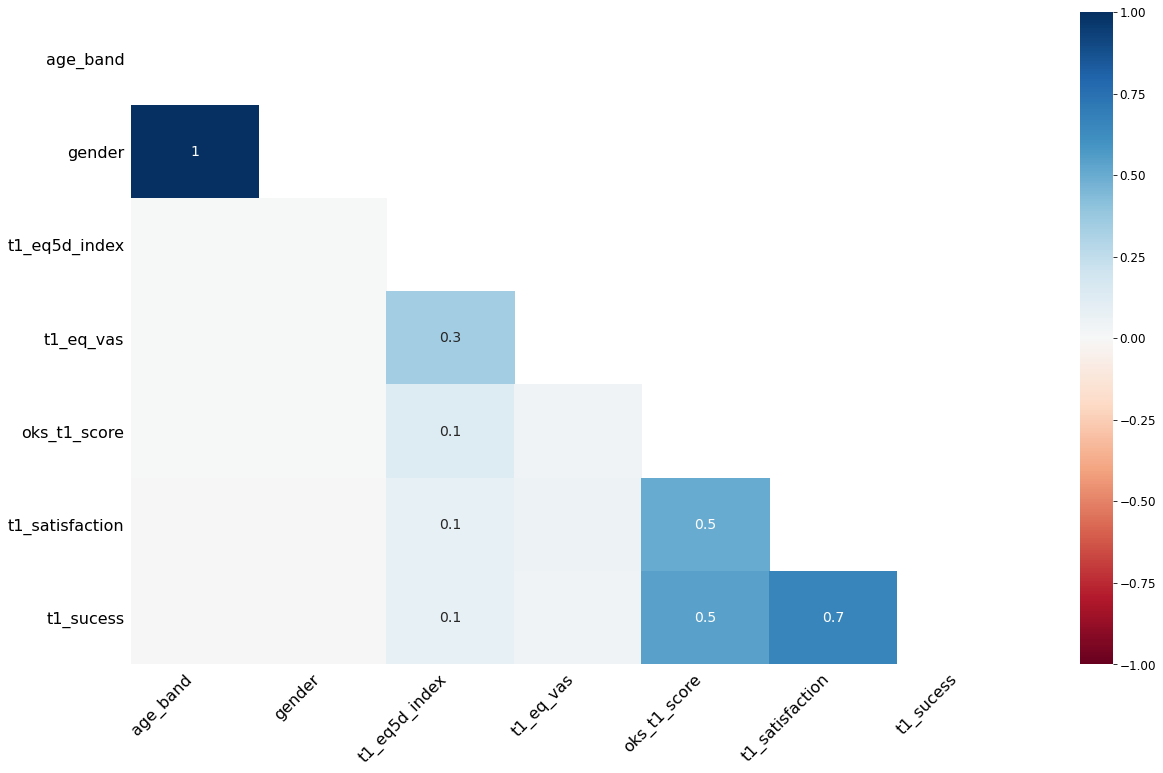

In [52]:

cols = ["age_band", 
        "gender",
        "t1_eq5d_index",
        "t1_eq_vas",
        "oks_t1_score",
        "t0_symptom_period",
        "t0_disability",
        "t1_satisfaction",
        "t1_sucess"]


msno.heatmap(df_knee[cols])

<AxesSubplot:>

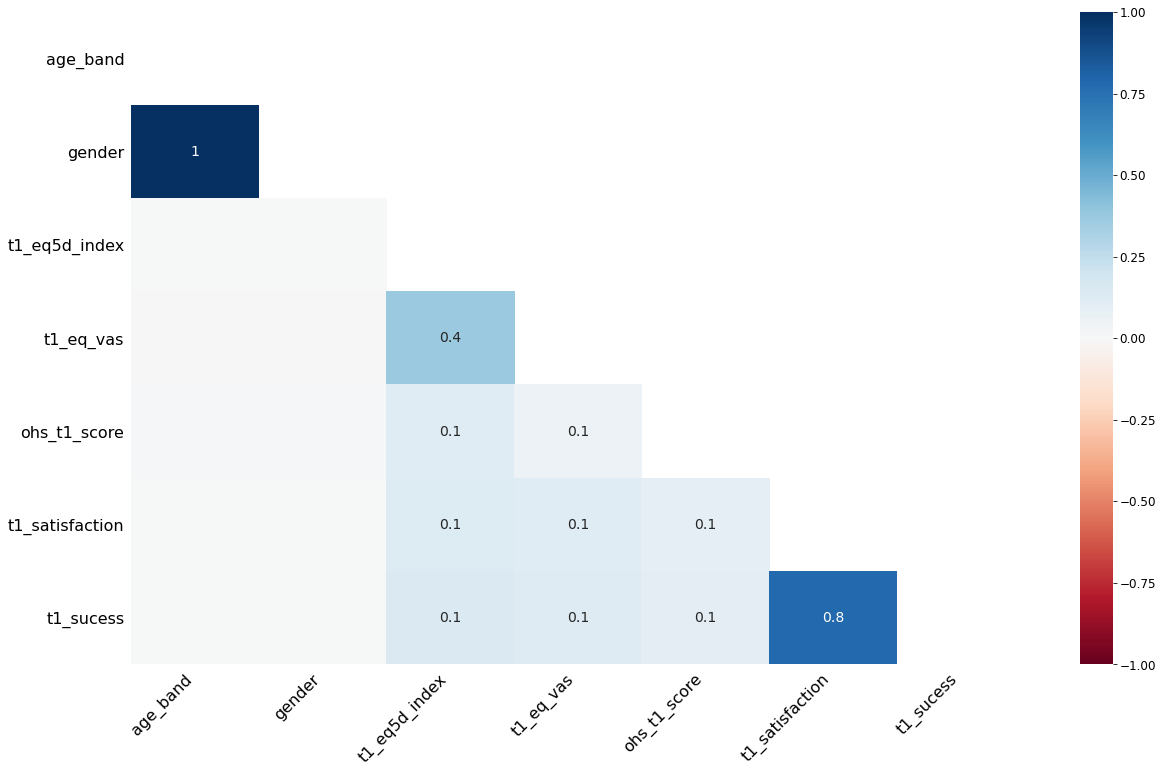

In [50]:
cols = ["age_band", 
        "gender",
        "t1_eq5d_index",
        "t1_eq_vas",
        "ohs_t1_score",
        "t0_symptom_period",
        "t0_disability",
        "t1_satisfaction",
        "t1_sucess"]
msno.heatmap(df_hip[cols])

In [42]:
(df_knee[EQ5D_t0_cols].isna().sum()/df_knee.shape[0])*100

t0_mobility      3.081047
t0_self_care     3.172427
t0_activity      3.234871
t0_discomfort    3.987237
t0_anxiety       3.700912
dtype: float64

In [43]:
(df_knee[EQ5D_t1_cols].isna().sum()/df_knee.shape[0])*100

t1_mobility      2.108606
t1_self_care     1.935744
t1_activity      2.172572
t1_discomfort    2.805382
t1_anxiety       2.259384
dtype: float64

In [44]:
(df_knee[OKS_t0_cols].isna().sum()/df_knee.shape[0])*100

oks_t0_pain          0.139355
oks_t0_night_pain    0.938935
oks_t0_washing       0.089858
oks_t0_transport     0.970157
oks_t0_walking       1.029554
oks_t0_standing      1.035646
oks_t0_limping       1.009755
oks_t0_kneeling      1.004424
oks_t0_work          0.970157
oks_t0_confidence    0.956450
oks_t0_shopping      0.964065
oks_t0_stairs        0.961780
dtype: float64

In [51]:
(df_knee[OKS_t1_cols].isna().sum()/df_knee.shape[0])*100

oks_t1_pain          0.919136
oks_t1_night_pain    0.630526
oks_t1_washing       0.882584
oks_t1_transport     0.876492
oks_t1_walking       0.908475
oks_t1_standing      0.717337
oks_t1_limping       0.783588
oks_t1_kneeling      0.786634
oks_t1_work          0.726475
oks_t1_confidence    0.674693
oks_t1_shopping      0.725714
oks_t1_stairs        0.704392
dtype: float64

In [55]:
(df_knee[EvaluationSurgery_cols].isna().sum()/df_knee.shape[0])*100

t1_satisfaction    1.448381
t1_sucess          1.249629
dtype: float64

In [56]:
(df_hip[EvaluationSurgery_cols].isna().sum()/df_hip.shape[0])*100

t1_satisfaction    1.571642
t1_sucess          1.432917
dtype: float64

In [58]:
(df_hip[EQ5D_t0_cols].isna().sum()/df_hip.shape[0])*100

t0_mobility      3.291486
t0_self_care     3.363864
t0_activity      3.431073
t0_discomfort    4.158302
t0_anxiety       3.871374
dtype: float64

In [57]:
(df_hip[EQ5D_t1_cols].isna().sum()/df_hip.shape[0])*100

t1_mobility      2.070534
t1_self_care     1.883557
t1_activity      2.098107
t1_discomfort    2.715907
t1_anxiety       2.136019
dtype: float64

In [59]:
(df_hip[OHS_t0_cols].isna().sum()/df_hip.shape[0])*100

ohs_t0_pain           0.146480
ohs_t0_sudden_pain    0.883187
ohs_t0_night_pain     0.860784
ohs_t0_washing        0.110291
ohs_t0_transport      0.912483
ohs_t0_dressing       0.915929
ohs_t0_shopping       0.922822
ohs_t0_walking        0.946948
ohs_t0_limping        0.883187
ohs_t0_stairs         0.941779
ohs_t0_standing       0.911621
ohs_t0_work           0.901281
dtype: float64

In [60]:
(df_hip[OHS_t1_cols].isna().sum()/df_hip.shape[0])*100

ohs_t1_pain           0.246431
ohs_t1_sudden_pain    0.617800
ohs_t1_night_pain     0.645373
ohs_t1_washing        0.238676
ohs_t1_transport      0.624693
ohs_t1_dressing       0.635033
ohs_t1_shopping       0.680700
ohs_t1_walking        0.858199
ohs_t1_limping        0.764280
ohs_t1_stairs         0.734984
ohs_t1_standing       0.697933
ohs_t1_work           0.748770
dtype: float64

<AxesSubplot:>

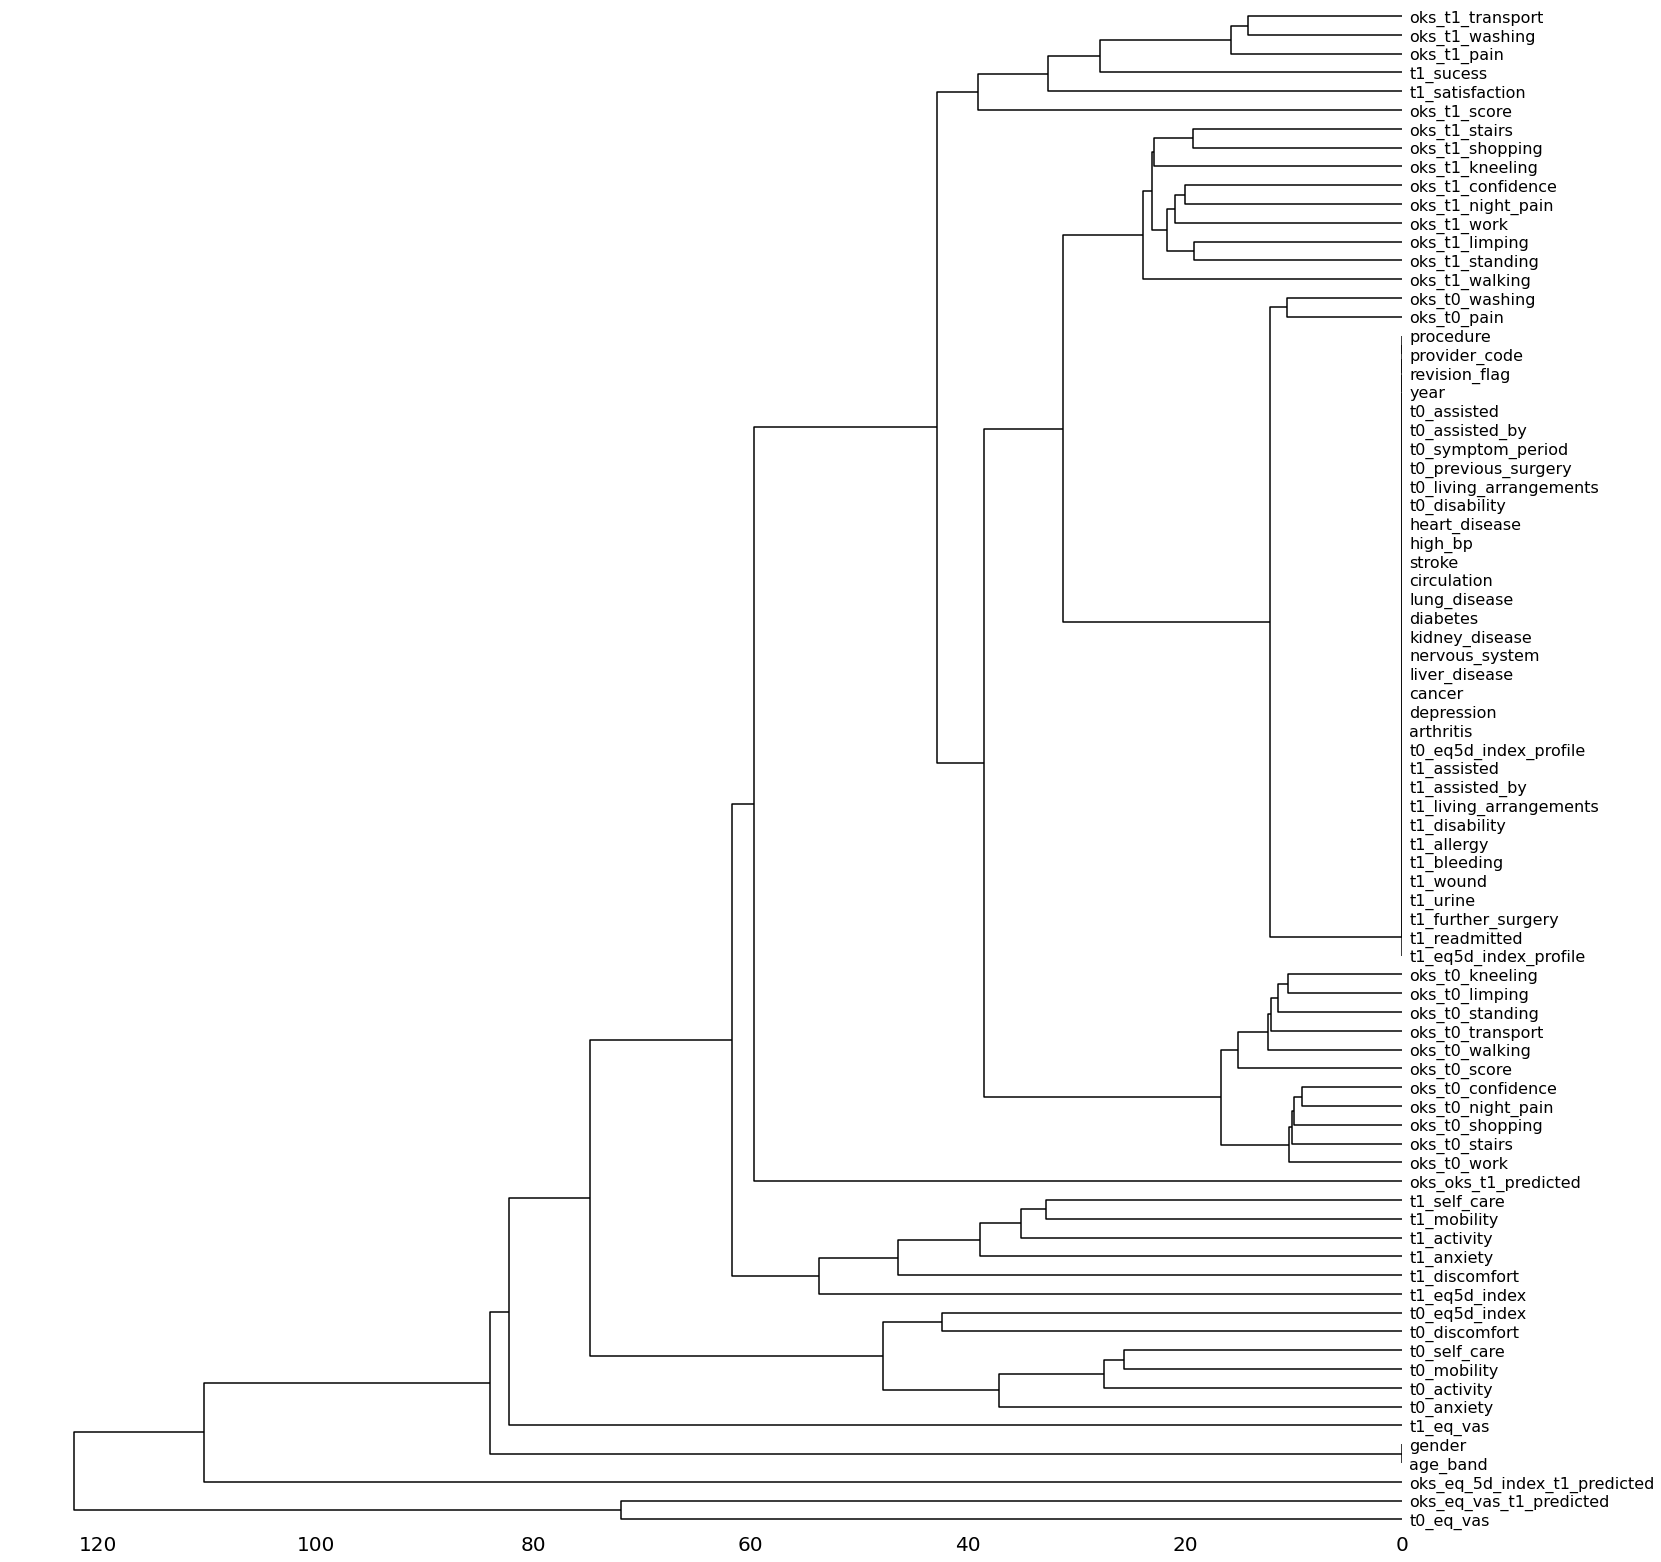

In [61]:
msno.dendrogram(df_knee)

<AxesSubplot:>

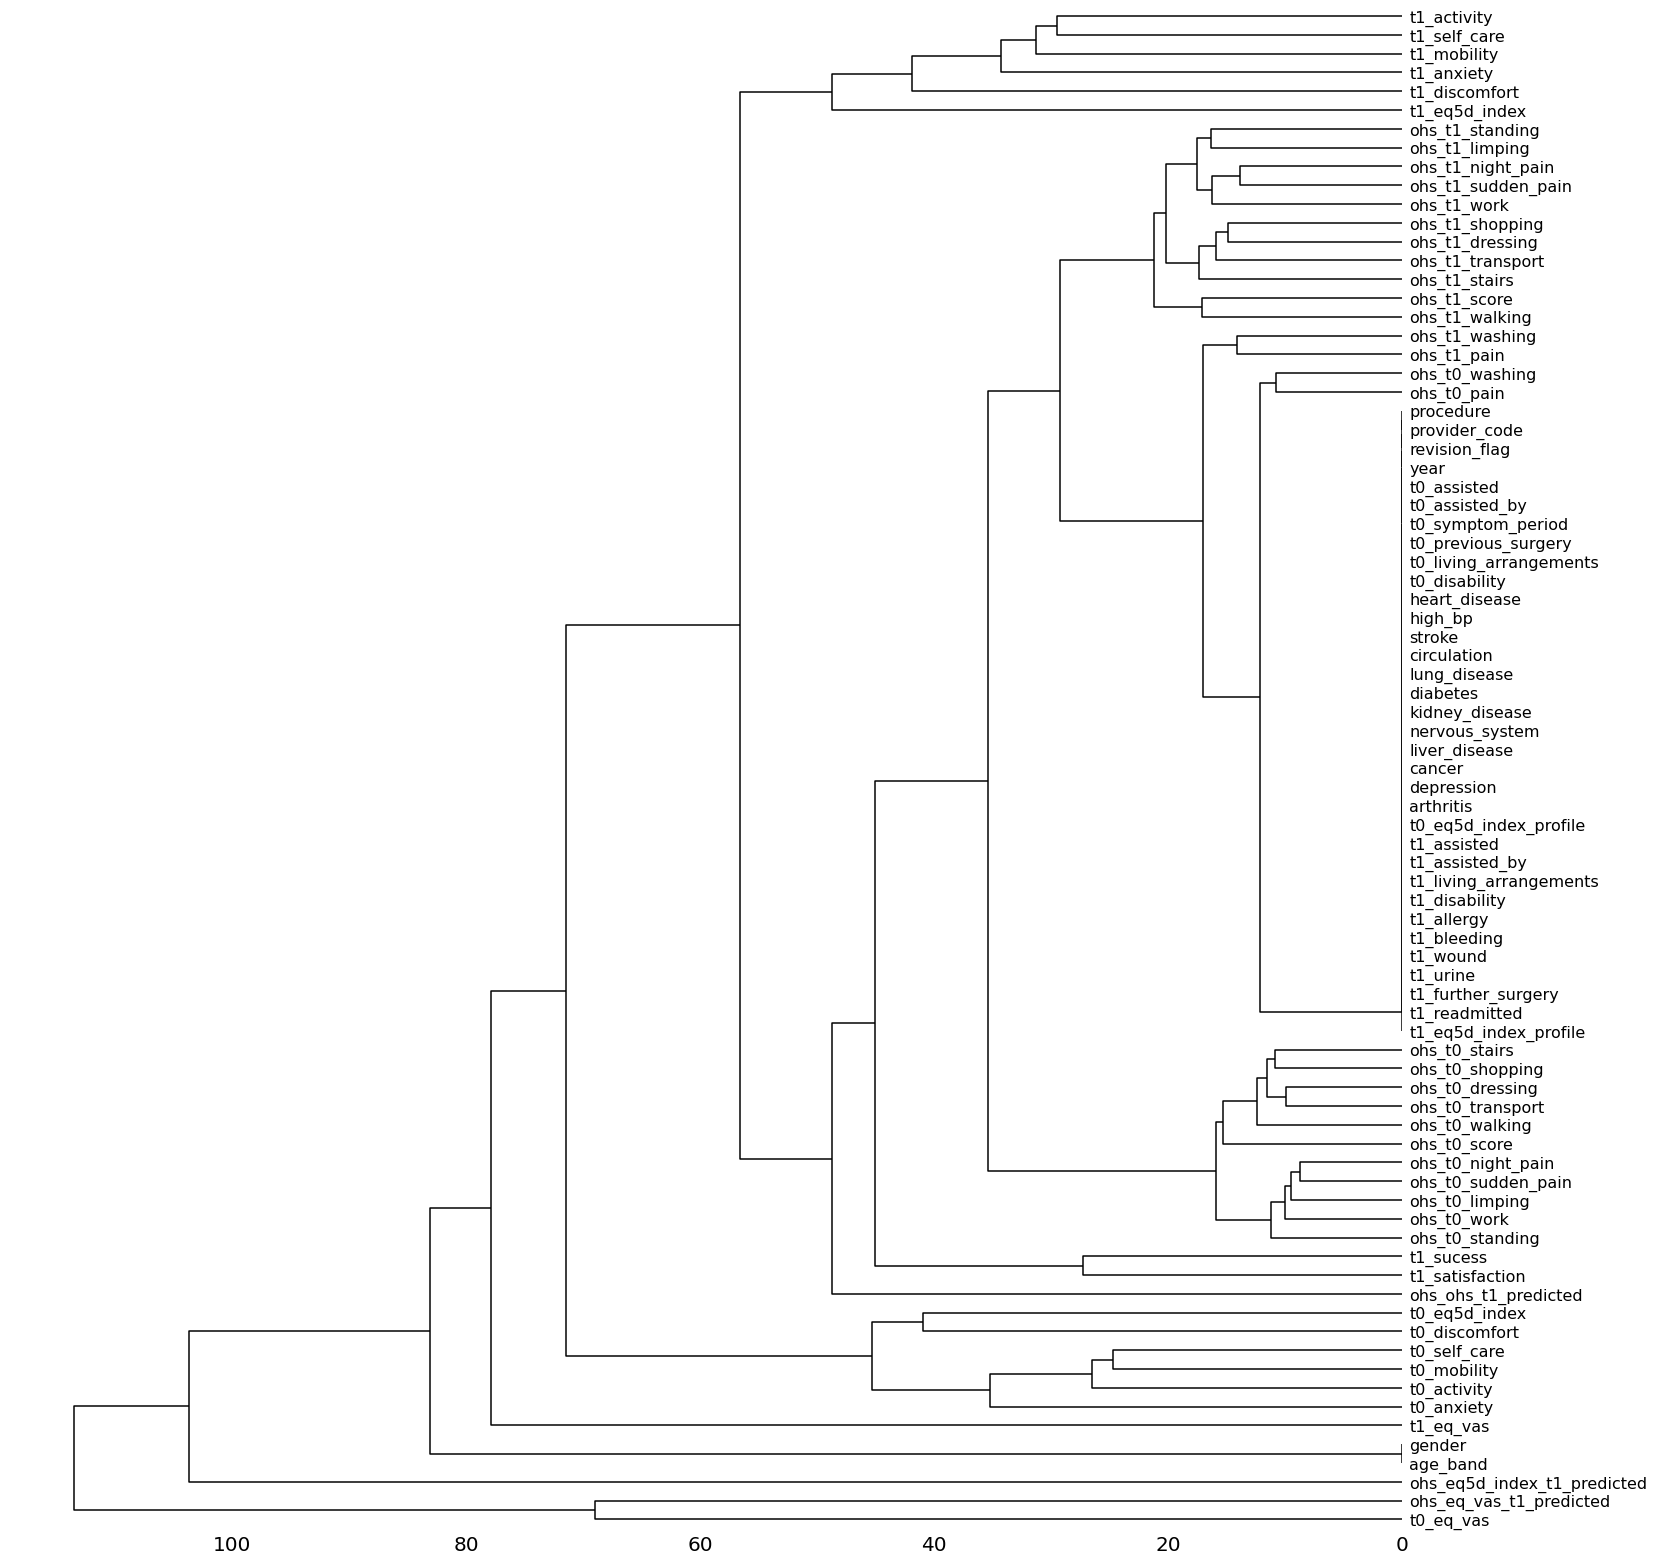

In [62]:
msno.dendrogram(df_hip)


Correlation matrix EQ5D and OKS scores for knee operation:


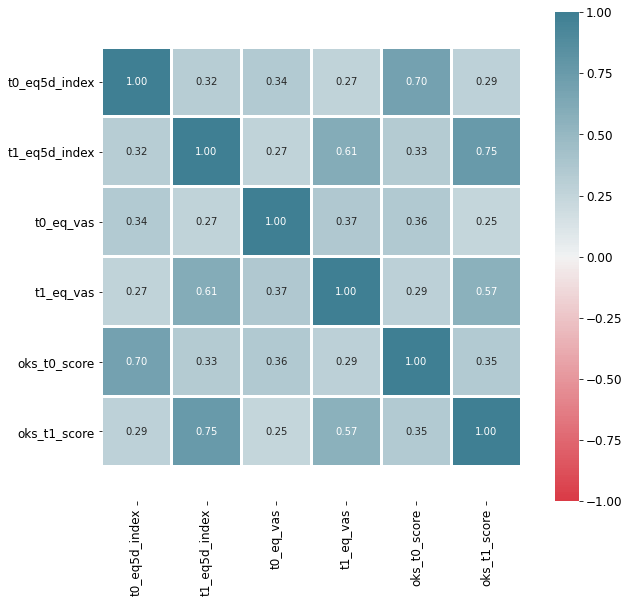

In [53]:
print("\nCorrelation matrix EQ5D and OKS scores for knee operation:")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    df_knee[TotalScoresKnee_cols].corr(),
    vmin=-1,
    vmax=1,
    square=True,
    cmap=sns.diverging_palette(10, 220, n=200),
    annot=True,
    linewidths=2,
    robust=True,
    fmt=".2f",
)
# to mitigate a bug that cuts the upper and bottom row in half.
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);


Correlation matrix EQ5D and OKS scores for hip operation


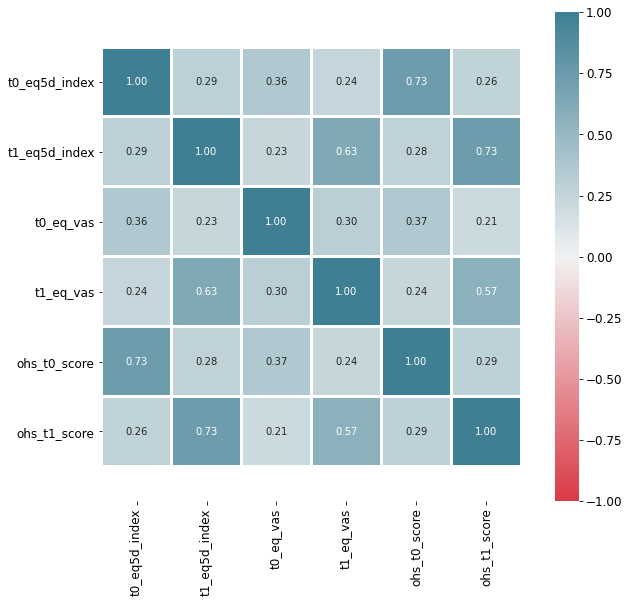

In [54]:
print("\nCorrelation matrix EQ5D and OKS scores for hip operation")
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    df_hip[TotalScoresHip_cols].corr(),
    vmin=-1,
    vmax=1,
    square=True,
    cmap=sns.diverging_palette(10, 220, n=200),
    annot=True,
    linewidths=2,
    robust=True,
    fmt=".2f",
)
# to mitigate a bug that cuts the upper and bottom row in half.
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5);

In [63]:
OKSitems = ["t1_mobility", 
            "t1_self_care", 
            "t1_activity", 
            "t1_discomfort", 
            "t1_anxiety",
            "oks_t1_pain", 
            "oks_t1_night_pain", 
            "oks_t1_washing", 
            "oks_t1_transport", 
            "oks_t1_walking", 
            "oks_t1_standing", 
            "oks_t1_limping", 
            "oks_t1_kneeling", 
            "oks_t1_work", 
            "oks_t1_confidence", 
            "oks_t1_shopping", 
            "oks_t1_stairs"]

OKSitems2 = ["t1_mobility", 
            "t1_self_care", 
            "t1_activity", 
            "t1_discomfort", 
            "t1_anxiety",
            "oks_t1_pain", 
            "oks_t1_night_pain", 
            "oks_t1_washing", 
            "oks_t1_transport", 
            "oks_t1_walking", 
            "oks_t1_standing", 
            "oks_t1_limping", 
            "oks_t1_kneeling", 
            "oks_t1_work", 
            "oks_t1_confidence", 
            "oks_t1_shopping", 
            "oks_t1_stairs",
            "t1_eq_vas"]




OHSitems = ["t1_mobility", 
            "t1_self_care", 
            "t1_activity", 
            "t1_discomfort", 
            "t1_anxiety",
            "ohs_t1_pain", 
            "ohs_t1_sudden_pain", 
            "ohs_t1_night_pain", 
            "ohs_t1_washing", 
            "ohs_t1_transport", 
            "ohs_t1_dressing", 
            "ohs_t1_shopping", 
            "ohs_t1_walking", 
            "ohs_t1_limping",
            "ohs_t1_stairs",
            "ohs_t1_standing",  
            "ohs_t1_work",
            "t1_eq_vas"]



In [67]:
Xk = df_knee[OKSitems2]
Xknee = Xk.dropna()

Xh = df_hip[OHSitems]
Xhip = Xh.dropna()

In [70]:
transformer = RobustScaler().fit(Xknee)
sXk = transformer.transform(Xknee)
sXknee = pd.DataFrame(sXk, columns = OKSitems2)

In [72]:
def rotateTickLabels(ax, rotation, which, rotation_mode='anchor', ha='left'):
    axes = []
    if which in ['x', 'both']:
        axes.append(ax.xaxis)
    elif which in ['y', 'both']:
        axes.append(ax.yaxis)
    for axis in axes:
        for t in axis.get_ticklabels():
            t.set_horizontalalignment(ha)
            t.set_rotation(rotation)
            t.set_rotation_mode(rotation_mode)

In [76]:
decomposer = PCA(n_components=3, random_state=SEED)
Xk_comp = decomposer.fit_transform(sXknee)

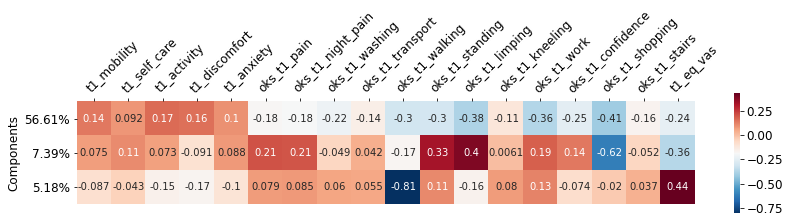

In [78]:
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(decomposer.components_, cmap='RdBu_r', annot=True, square=True, cbar_kws={"shrink": .25})
ax.xaxis.set_ticks_position('top')
rotateTickLabels(ax, 45, 'x')
ax.xaxis.set_ticklabels(sXknee.keys(), fontsize=12)
y_ticks = ['%.2f%%' % ev for ev in np.round(decomposer.explained_variance_ratio_*100, decimals=2)]
ax.yaxis.set_ticklabels(y_ticks, fontsize=12, rotation=0)
plt.ylabel('Components', fontsize=12)
plt.tight_layout()
plt.savefig('PCA_VAS_OKS.png')
plt.show()

In [79]:
transformer = RobustScaler().fit(Xhip)
sXh = transformer.transform(Xhip)
sXhip = pd.DataFrame(sXh, columns = OHSitems)

In [80]:
decomposer = PCA(n_components=3, random_state=SEED)
Xh_comp = decomposer.fit_transform(sXhip)

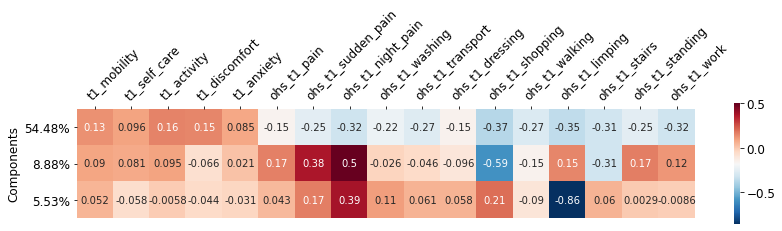

In [81]:
f, ax = plt.subplots(figsize=(12, 7))
sns.heatmap(decomposer.components_, cmap='RdBu_r', annot=True, square=True, cbar_kws={"shrink": .25})
ax.xaxis.set_ticks_position('top')
rotateTickLabels(ax, 45, 'x')
ax.xaxis.set_ticklabels(sXhip.keys(), fontsize=12)
y_ticks = ['%.2f%%' % ev for ev in np.round(decomposer.explained_variance_ratio_*100, decimals=2)]
ax.yaxis.set_ticklabels(y_ticks, fontsize=12, rotation=0)
plt.ylabel('Components', fontsize=12)
plt.tight_layout()
plt.savefig('PCA_VAS_OHS.png')
plt.show()